# Phase 3: Gradient Boost Classifier

In [ ]:
from Preprocessing import *;
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split,cross_val_score;
from sklearn.preprocessing import LabelEncoder, OneHotEncoder;
from sklearn.ensemble import GradientBoostingClassifier as GBC;
from sklearn.metrics import log_loss, confusion_matrix, classification_report;
from sklearn.feature_extraction.text import TfidfVectorizer;
from pandas.api.types import CategoricalDtype
from xgboost import XGBClassifier
plt.style.use('ggplot')

In [2]:
data = train_df.reset_index(drop=True)

## Processing test dataset

In [218]:
test = pd.read_json("test.json")
test = test.reset_index(drop=True)

In [219]:
# convert column to datetime
test["created"] = pd.to_datetime(test["created"])
# add hour created column
test["hour_created"] = test["created"].dt.hour

In [220]:
# label encode
test["address"] = test["display_address"].astype('category')
test["address"] = test["address"].cat.codes
test["manager_id"] = test["manager_id"].astype('category')
test["manager"] = test["manager_id"].cat.codes
test.drop(['manager_id'], axis=1, inplace=True)
test["building_id"] = test["building_id"].astype('category')
test["building"] = test["building_id"].cat.codes
test.drop(['building_id'], axis=1, inplace=True)

In [221]:
# convert features list to string
test['features'] = test['features'].apply(lambda x: ' '.join(x))

In [223]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', token_pattern=r'^[a-zA-Z][a-zA-Z][a-zA-Z]+', max_features=79)
vectorizer.fit(test['features'].values);
test['feat_vect'] = test['features'].apply(lambda x: vectorizer.transform([x]))

In [224]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', token_pattern=r'^[a-zA-Z][a-zA-Z][a-zA-Z]+', max_features=1119)
vectorizer.fit(test['description'].values);
test['desc_vect'] = test['description'].apply(lambda x: vectorizer.transform([x]))

In [225]:
test.drop(['photos','street_address','features','description','created','display_address'], axis=1, inplace=True)

# 1. Feature Selection

Since the listing_id is unique to each lising, it really isn't relevant for our model and will be removed. We will also remove the photos column because we won't be using this in our model either. We will also remove street_address because we can use the display_address as a categorical value since this is just the general street that the listing is on. This helps identify the general neighbourhood the listing is in for the buyer. The description, created, and features columns are removed because these are represented by newly extracted feature columns from the previous milestone.

In [12]:
data.drop(['photos','listing_id','street_address','features','description','created'], axis=1, inplace=True)

## Binarize data by label encoding

In [13]:
cat_type = CategoricalDtype(categories=["high", "medium", "low"],ordered=True)
cat_type

CategoricalDtype(categories=[u'high', u'medium', u'low'], ordered=True)

In [14]:
# high-0, medium-1, low-2
data["interest_level"] = data["interest_level"].astype(cat_type)
data["target"] = data["interest_level"].cat.codes
data.drop(['interest_level'], axis=1, inplace=True)

In [15]:
data["address"] = data["display_address"].astype('category')
data["address"] = data["address"].cat.codes
data.drop(['display_address'], axis=1, inplace=True)

In [16]:
data["building_id"] = data["building_id"].astype('category')
data["building"] = data["building_id"].cat.codes
data.drop(['building_id'], axis=1, inplace=True)

In [17]:
data["manager_id"] = data["manager_id"].astype('category')
data["manager"] = data["manager_id"].cat.codes
data.drop(['manager_id'], axis=1, inplace=True)

## Split the data

I will split our input and target variables into X and y respectively. We will also split into training and test data so we can see if our models are overfitting the data.

In [26]:
X = data.drop(['target'], axis=1)
y = data['target']
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [27]:
X.reset_index(inplace=True,drop=True)
y.reset_index(inplace=True,drop=True)

## Fisher score

Since this is only valid for numerica features, we must first take a subset of our data. We will separate the data based on interest level to calculate the mean and standard deviation of each class. These values will be used to calculate the fisher score for each feature. We can then use a filtering technique to find the most relevant features based on the scores. 

In [20]:
# take subset
numeric = ['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building']
all_feats = ['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building','desc_vect','feat_vect']
num_data = data[['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building','target']]

In [16]:
# separate data by interest level
high = num_data[num_data['target'] == 2].drop(['target'], axis=1)
med = num_data[num_data['target'] == 1].drop(['target'], axis=1)
low = num_data[num_data['target'] == 0].drop(['target'], axis=1)

In [17]:
# calculate mean of each feature in each class
avg_if = np.array([high.mean(),
      med.mean(),
      low.mean()])
#calculate mean of each feature
avg_f = np.array(num_data.drop(['target'], axis=1).mean())

In [18]:
# calculate variance for each feature
var = np.square(np.array([high.std(),
      med.std(),
      low.std()]))

# calculate probability of each class
prob = np.array([high.shape[0]/float(data.shape[0]),
             med.shape[0]/float(data.shape[0]),
             low.shape[0]/float(data.shape[0])]
)

In [19]:
fisher = []
numerator = []
denomerator = []

for feat in np.arange(0,avg_if.shape[1]):
    for class_i in np.arange(0,avg_if.shape[0]):
        numerator.append(np.array(prob[class_i]*np.square(avg_if[class_i][feat]-avg_f[feat])))
        denomerator.append(np.array(prob[class_i]*var[class_i]))      
    fisher.append(np.array(numerator).sum()/np.array(denomerator).sum())
fisher

[1.4391986856950884e-10,
 1.5495308224893388e-10,
 1.0336764419360136e-10,
 7.75380886324851e-11,
 0.0008348517025325086,
 0.000695716318490876,
 0.0011911021471335808,
 0.0010447074295786081,
 0.0019208781511415576]

In [21]:
top3 = ['building', 'manager', 'address']
top5 = ['building', 'manager', 'address','price', 'hour_created']

From the Fisher scores, it looks like the building, address, and manager have the top 3 fisher scores, in that order.  Price and hour the listing was created also have decent fisher scores. The worst was longitude and the rest weren't that far off either with 10 significant digits. 

# 2. Train Classifiers

Used as a guideline for improvements: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

## Helper Functions

In [22]:
# set default hyperparameters
N_EST = 100
DEPTH = 3
RATE = 0.1
MIN_SAMP = 1

In [23]:
global listing_id;
listing_id = test['listing_id'].values
listing_id = listing_id.reshape(listing_id.shape[0],1)

In [24]:
def train(kf,train_df,test_df,n_est,depth,min_leaf,rate):
    model_gbc = GBC(n_estimators=n_est, random_state=0,max_depth=depth,min_samples_leaf=min_leaf, learning_rate=rate)
    model_gbc = model_gbc.fit(np.array(train_df),np.array(y_tr))
    y_prob = model_gbc.predict_proba(test_df)
    y_pred = model_gbc.predict(test_df)
    loss = log_loss(y_test, y_prob)
    #acc = accuracy_score(y_test, y_pred)
    results_gbc = cross_val_score(model_gbc, train_df, y_tr, cv=kf, scoring='neg_log_loss')
    print_results(results_gbc,loss)
    return y_prob, y_pred, model_gbc

def print_results(results_gbc, loss):
    print('Cross validation results:\n'
          'Negative log loss of folds: {0}\n'
          'Mean log loss of all folds: {1} (+/-{2})\n'
          'Test log loss: {3}'.format(results_gbc,results_gbc.mean(),results_gbc.std(),loss))

def testing(model_gbc, test_df,version):
    # use best classifier on test dataset
    y_pred = model_gbc.predict_proba(test_df)
    # Test output for log loss
    test_prob = np.concatenate((listing_id,y_pred),axis=1)
    np.savetxt('test_v{}.csv'.format(version),test_prob, delimiter=',',header='listing_id,high,medium,low',encoding='ascii')

## First Version

The first version used all numeric features. Regular cross validation with 5 folds was used. Number of estimators was the default 100. Kaggle score: 0.65793. 

In [27]:
# second time
kf = KFold(n_splits=5, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],100,DEPTH,MIN_SAMP,RATE)

Cross validation results:
Negative log loss of folds: [-0.61973552 -0.6375119  -0.64126953 -0.62879089 -0.64435558]
Mean log loss of all folds: -0.634332683827 (+/-0.00897189450249)
Test log loss: 0.638684922517


In [196]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.62      0.18      0.28       965
      medium       0.46      0.17      0.25      2836
         low       0.74      0.96      0.84      8499

   micro avg       0.72      0.72      0.72     12300
   macro avg       0.61      0.44      0.46     12300
weighted avg       0.67      0.72      0.66     12300



In [54]:
testing(model_gbc,test[numeric],1)

## Second Version

Top 5 features according to Fisher scores were used for this classifier. This version did worse than the first in both training and test data. Precesion for all classes was also lower. 

In [28]:
kf = KFold(n_splits=5, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[top5],X_test[top5],100,DEPTH,MIN_SAMP,RATE)
#(y_prob, y_pred, model_gbc) = train(kf,100,top5)

Cross validation results:
Negative log loss of folds: [-0.66355568 -0.67614683 -0.68068219 -0.66943808 -0.68121573]
Mean log loss of all folds: -0.674207701171 (+/-0.00679715445783)
Test log loss: 0.681156105594


In [61]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.54      0.15      0.24       965
      medium       0.44      0.11      0.18      2836
         low       0.73      0.97      0.83      8499

   micro avg       0.71      0.71      0.71     12300
   macro avg       0.57      0.41      0.41     12300
weighted avg       0.65      0.71      0.63     12300



In [62]:
testing(model_gbc,test[top5],2)

## Third Version

All numeric features were used for this classifier. 10 folds were used. Testing log loss (0.71) was actually higher than validation (mean -0.634304785285 (+/-0.0115601003865)).

In [28]:
kf = KFold(n_splits=10, random_state=0) #random state was 10 for output
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],100,DEPTH,MIN_SAMP,RATE)
#(y_prob, y_pred, model_gbc) = train(kf,100,numeric)

Cross validation results:
Negative log loss of folds: [-0.65146836 -0.62566497 -0.60734555 -0.63426111 -0.62017785 -0.64714128
 -0.64268538 -0.64221236 -0.63948399 -0.64690496]
Mean log loss of all folds: -0.635734581048 (+/-0.013260062578)
Test log loss: 0.627822368209


In [29]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.61      0.17      0.27       743
      medium       0.45      0.17      0.25      2246
         low       0.75      0.96      0.84      6851

   micro avg       0.72      0.72      0.72      9840
   macro avg       0.60      0.43      0.45      9840
weighted avg       0.67      0.72      0.66      9840



In [69]:
testing(model_gbc,test[numeric],3)

## Fourth Version

We can check the distribution of the target to see if stratifying the samples will help us identify any under-represented classes.

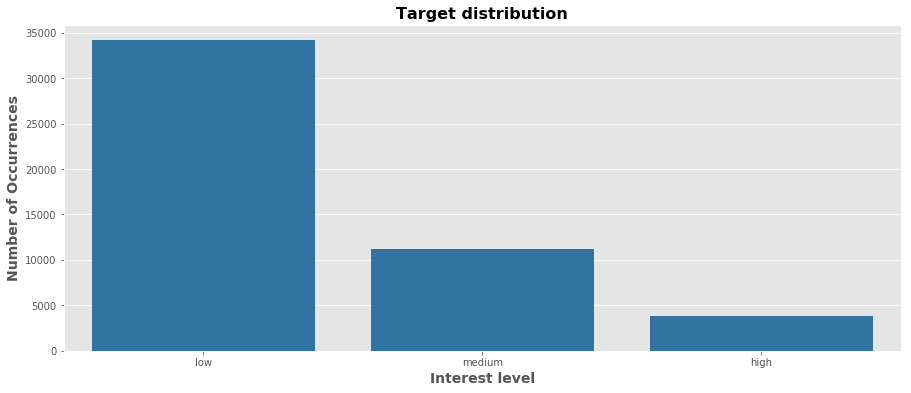

In [36]:
int_level = train_df['interest_level'].value_counts()
plt.figure(figsize=(15,6))
sns.barplot(int_level.index, int_level.values, alpha=1, order=['low','medium','high'],color=color[0])
plt.ylabel('Number of Occurrences', fontsize=14, fontweight='bold')
plt.xlabel('Interest level', fontsize=14, fontweight='bold')
plt.title('Target distribution', fontsize=16, fontweight='bold')
plt.show()

In [37]:
int_all = int_level.sum()
prob_h = int_level[0]/float(int_all)
prob_m = int_level[1]/float(int_all)
prob_l = int_level[2]/float(int_all)
print(prob_h, prob_m, prob_l)

(0.6947578104355957, 0.2276358314531374, 0.07760635811126694)


Since the distribution of our target is skewed, we should stratify our data when spliting so it represents our data well. All numeric features were used for this classifier. A stratified k-fold cross validation method was used. The classifier predicted with average 71.59, which is the same as regular k-fold cross validation.

In [45]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],100,DEPTH,MIN_SAMP,RATE)
#(y_prob, y_pred, model_gbc) = train(kf,100,numeric)

Cross validation results:
Negative log loss of folds: [-0.6259658  -0.64972545 -0.63965819 -0.63920031 -0.63240227 -0.63434838
 -0.63813548 -0.63101538 -0.65129083 -0.6428751 ]
Mean log loss of all folds: -0.638461718276 (+/-0.00760428659045)
Test log loss: 0.624446851318


In [46]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.60      0.16      0.26       945
      medium       0.48      0.19      0.27      2788
         low       0.75      0.96      0.85      8567

   micro avg       0.73      0.73      0.73     12300
   macro avg       0.61      0.44      0.46     12300
weighted avg       0.68      0.73      0.67     12300



In [68]:
testing(model_gbc,test[numeric],4)

## Fifth Version

All numeric features were used for this classifier. Number of estimators was increased to 150. A stratified k-fold cross validation method was used. The classifier predicted with average 63.40% validation log loss. OVerfitting is occuring because the test log loss is slightly better at 61.54%.

In [42]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],150,DEPTH,MIN_SAMP,RATE)
#(y_prob, y_pred, model_gbc) = train(kf,150,numeric)

Cross validation results:
Negative log loss of folds: [-0.61822483 -0.64234056 -0.63176158 -0.63191878 -0.62326404 -0.62596735
 -0.63093361 -0.62147791 -0.64252866 -0.63553867]
Mean log loss of all folds: -0.630395597817 (+/-0.00786728263729)
Test log loss: 0.61539739534


In [43]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.59      0.17      0.26       945
      medium       0.48      0.22      0.30      2788
         low       0.76      0.96      0.85      8567

   micro avg       0.73      0.73      0.73     12300
   macro avg       0.61      0.45      0.47     12300
weighted avg       0.69      0.73      0.68     12300



In [44]:
testing(model_gbc,test[numeric],5)

## Sixth Version

All numeric features were used for this classifier. Number of estimators was increased to 200. A stratified k-fold cross validation method was used. The classifier predicted with average 62.63% log loss on validation. Since boosting selects the best features for the next stage, its better to start with more features. Overfitting is occurring since our test log loss is higher than validation. 

In [30]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],150,DEPTH,MIN_SAMP,RATE)
#(y_prob, y_pred, model_gbc) = train(kf,200,numeric)

Cross validation results:
Negative log loss of folds: [-0.63722464 -0.61450809 -0.61384699 -0.63064995 -0.62008363 -0.63869145
 -0.6267715  -0.63231959 -0.63207107 -0.62879994]
Mean log loss of all folds: -0.627496683717 (+/-0.00828420006427)
Test log loss: 0.618917899605


In [31]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.60      0.18      0.28       743
      medium       0.46      0.20      0.28      2246
         low       0.76      0.95      0.84      6851

   micro avg       0.72      0.72      0.72      9840
   macro avg       0.60      0.44      0.47      9840
weighted avg       0.68      0.72      0.67      9840



In [75]:
testing(model_gbc,test[numeric],6)

## Seventh Version

Minimum samples per leaf = 20, 200 estimators, numeric features

In [189]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],200,DEPTH,20,RATE)

Cross validation results:
Negative log loss of folds: [-0.60699157 -0.61433355 -0.62227766 -0.62186212 -0.62982236 -0.62762845
 -0.62170407 -0.62631502 -0.61222444 -0.61219917]
Mean log loss of all folds: -0.619535840986 (+/-0.00725669600167)
Test log loss: 0.619775995079


In [190]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.60      0.21      0.31       965
      medium       0.48      0.22      0.30      2836
         low       0.76      0.95      0.84      8499

   micro avg       0.72      0.72      0.72     12300
   macro avg       0.61      0.46      0.48     12300
weighted avg       0.68      0.72      0.68     12300



In [75]:
testing(model_gbc,test[numeric],7)

## Eigth Version

K fold with 5 folds, 50 estimators.

In [191]:
kf = KFold(n_splits=5, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],50,DEPTH,MIN_SAMP,RATE)
#(y_prob, y_pred, model_gbc) = train(kf,50,numeric)

Cross validation results:
Negative log loss of folds: [-0.64328498 -0.65939972 -0.65768837 -0.65962024 -0.63671908]
Mean log loss of all folds: -0.651342478734 (+/-0.00951291501842)
Test log loss: 0.619775995079


In [192]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.60      0.17      0.26       965
      medium       0.44      0.12      0.19      2836
         low       0.73      0.97      0.83      8499

   micro avg       0.71      0.71      0.71     12300
   macro avg       0.59      0.42      0.43     12300
weighted avg       0.65      0.71      0.64     12300



In [193]:
testing(model_gbc,test[numeric],8)

## Ninth Version

Minimum samples per leaf = 20, 250 estimators, numeric features

In [29]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],250,DEPTH,20,RATE)
# model_gbc = GBC(n_estimators=250, random_state=0,min_samples_leaf=20)
# model_gbc = model_gbc.fit(np.array(X_tr[numeric]),np.array(y_tr))
# y_pred = model_gbc.predict(X_test[numeric])
# y_prob = model_gbc.predict_proba(X_test[numeric])
# loss = log_loss(y_test, y_prob)
# results_gbc = cross_val_score(model_gbc, X_tr[numeric], y_tr, cv=kf, scoring='neg_log_loss')
# print_results(results_gbc,loss)

Cross validation results:
Negative log loss of folds: [-0.61137811 -0.60568171 -0.61866023 -0.62081814 -0.62183886 -0.61919955
 -0.6100559  -0.61013176 -0.62320911 -0.61524715]
Mean log loss of all folds: -0.615622051328 (+/-0.00568619178616)
Test log loss: 0.617675695196


In [30]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.63      0.20      0.31      1032
      medium       0.45      0.25      0.32      2770
         low       0.77      0.95      0.85      8498

   micro avg       0.73      0.73      0.73     12300
   macro avg       0.62      0.46      0.49     12300
weighted avg       0.69      0.73      0.68     12300



In [31]:
testing(model_gbc,test[numeric],9)

## Tenth Version

Minimum samples per leaf = 40, 250 estimators, numeric features. Kaggle score 0.64874.

In [32]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],150,DEPTH,MIN_SAMP,RATE)
# model_gbc = GBC(n_estimators=250, random_state=0,min_samples_leaf=40)
# model_gbc = model_gbc.fit(np.array(X_tr[numeric]),np.array(y_tr))
# y_pred = model_gbc.predict(X_test[numeric])
# y_prob = model_gbc.predict_proba(X_test[numeric])
# loss = log_loss(y_test, y_prob)
# results_gbc = cross_val_score(model_gbc, X_tr[numeric], y_tr, cv=kf, scoring='neg_log_loss')
# print_results(results_gbc,loss)

Cross validation results:
Negative log loss of folds: [-0.6091785  -0.60662281 -0.61918619 -0.6201973  -0.62173282 -0.61900322
 -0.60964536 -0.60848237 -0.6220913  -0.61536997]
Mean log loss of all folds: -0.615150983717 (+/-0.00575592699681)
Test log loss: 0.617644632047


In [33]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.63      0.20      0.31      1032
      medium       0.46      0.25      0.32      2770
         low       0.77      0.95      0.85      8498

   micro avg       0.73      0.73      0.73     12300
   macro avg       0.62      0.47      0.49     12300
weighted avg       0.69      0.73      0.68     12300



In [34]:
testing(model_gbc,test[numeric],10)

## Eleventh Version

Minimum samples per leaf = 40, 250 estimators, numeric features. large max depth leads to poor performance.

In [35]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X_tr[numeric],X_test[numeric],250,100,40,RATE)
# model_gbc = GBC(n_estimators=250, random_state=0,min_samples_leaf=40, max_depth=100)
# model_gbc = model_gbc.fit(np.array(X_tr[numeric]),np.array(y_tr))
# y_pred = model_gbc.predict(X_test[numeric])
# y_prob = model_gbc.predict_proba(X_test[numeric])
# loss = log_loss(y_test, y_prob)
# results_gbc = cross_val_score(model_gbc, X_tr[numeric], y_tr, cv=kf, scoring='neg_log_loss')
# print_results(results_gbc,loss)

Cross validation results:
Negative log loss of folds: [-0.90902446 -0.91916288 -0.96459158 -0.92858905 -0.94383585 -0.95762887
 -0.90203827 -0.90215749 -0.95564485 -0.96289153]
Mean log loss of all folds: -0.934556482742 (+/-0.0240826265889)
Test log loss: 0.931281869119


In [36]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.50      0.30      0.37      1032
      medium       0.45      0.39      0.41      2770
         low       0.81      0.88      0.84      8498

   micro avg       0.72      0.72      0.72     12300
   macro avg       0.58      0.52      0.54     12300
weighted avg       0.70      0.72      0.71     12300



In [37]:
testing(model_gbc,test[numeric],11)

## Twelfth Version

We can introduce our extracted text features for this version. Number of estimators = 250, Min samples per leaf = 40

### Hot encode features vector

The Decision Tree classifier in the sklearn sorts each feature to split the data and doesn't support features that are vectors.

In [193]:
def csr_to_list(df):
    feat = df.apply(lambda x: x.toarray().tolist())
    feat_list = []
    for i in feat:
        feat_list.append(i)
    return feat_list

def hot_encode(old_df, feature):
    feat_list = csr_to_list(old_df[feature])
    encoded = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))
    return old_df[numeric].join(encoded)

In [226]:
# hot encode split from train.json
X2 = hot_encode(X_tr,'feat_vect')
X3 = hot_encode(X_tr,'desc_vect')
# hot encode features in X_test used in cross validation (subset of train.json)
X_test2 = hot_encode(X_test, 'feat_vect')
# X_test dataset for testing validation (subset)
X_test3 = hot_encode(X_test, 'desc_vect')
# hot encode features in test.json
test2 = hot_encode(test, 'feat_vect')
# hot enode description in test.json
test3 = hot_encode(test,'desc_vect')

In [227]:
# combine X_tr with hot encoded description and features 
X3 = pd.merge(X2, X3, on=numeric, right_index=True, left_index=True,suffixes=('_feat', '_desc'))
# combine dataframes with hot encoded description and features in test.json
test3 = pd.merge(test2, test3, on=numeric, right_index=True, left_index=True, suffixes=('_feat', '_desc'))
X_test3 = pd.merge(X_test2, X_test3, on=numeric, right_index=True, left_index=True, suffixes=('_feat', '_desc'))

In [ ]:
# fill any nan values with 0.0
X_test2 = X_test2.fillna(0.0)
X_test3 = X_test3.fillna(0.0)
X2 = X2.fillna(0.0)
X3 = X3.fillna(0.0)

In [229]:
test2

,bathrooms,bedrooms,latitude,longitude,price,hour_created,address,manager,building,0,...,69,70,71,72,73,74,75,76,77,78
0,1.0,1,40.7185,-73.9865,2950,5,9506,2694,4412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,40.7278,-74.0000,2850,6,9589,3145,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1,40.7306,-73.9890,3758,4,660,2346,2257,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2,40.7109,-73.9571,3300,6,318,179,4368,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,2,40.7650,-73.9845,4900,5,8767,2764,3530,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,3,40.7901,-73.9774,9000,6,10826,2259,5678,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,2,40.7730,-73.9571,2800,3,7117,1205,4676,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0,40.6751,-73.9511,1900,6,9283,198,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,2,40.7597,-73.9929,3000,5,11128,3467,2338,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0,40.7208,-73.9887,2300,3,9009,381,4516,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


All numeric features and the hot encoded features were used for this classifier.  A stratified k-fold cross validation method was used. Using the features vectors has slight improvements to the model in terms of log loss although the f1-scores are slightly worse. Kaggle score 0.64194 which is the best so far.

In [41]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X2,X_test2,250,DEPTH,40,RATE)
# model_gbc = GBC(n_estimators=250, random_state=0,min_samples_leaf=40)
# model_gbc = model_gbc.fit(np.array(X2),np.array(y_tr))
# y_pred = model_gbc.predict(X_test2)
# y_prob = model_gbc.predict_proba(X_test2)
# loss = log_loss(y_test, y_prob)
# results_gbc = cross_val_score(model_gbc, X2, y_tr, cv=kf, scoring='neg_log_loss')
# print_results(results_gbc,loss)

Cross validation results:
Negative log loss of folds: [-0.60946043 -0.61094254 -0.61582137 -0.61790958 -0.60963592 -0.62100167
 -0.60996035 -0.59826194 -0.61200994 -0.6217635 ]
Mean log loss of all folds: -0.612676724139 (+/-0.00653722790083)
Test log loss: 0.608261228172


In [42]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.60      0.19      0.29       980
      medium       0.45      0.25      0.32      2719
         low       0.77      0.94      0.85      8601

   micro avg       0.73      0.73      0.73     12300
   macro avg       0.61      0.46      0.49     12300
weighted avg       0.69      0.73      0.69     12300



In [96]:
# output csv probabilities for kaggle
testing(model_gbc,test2,12)

## Thirteenth Version

Minimum samples per leaf = 40, 400 estimators, numeric features. We can decrease the learning rate in this version. Since trees are added sequentially, we can reduce the impact of them so that it leaves more room for future trees to improve the model. There is a tradeoff with learning rate and number of trees. So this model is a lot slower than previous ones.

In [152]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X2,X_test2,400,2,40,0.05)

Cross validation results:
Negative log loss of folds: [-0.62967453 -0.60693647 -0.60715173 -0.62553411 -0.61535682 -0.63203936
 -0.6218493  -0.62450491 -0.62642    -0.62360971]
Mean log loss of all folds: -0.621307695749 (+/-0.00829048672893)
Test log loss: 0.613518371315


In [106]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.63      0.18      0.28       980
      medium       0.44      0.24      0.31      2719
         low       0.77      0.94      0.85      8601

   micro avg       0.73      0.73      0.73     12300
   macro avg       0.61      0.45      0.48     12300
weighted avg       0.69      0.73      0.68     12300



In [107]:
testing(model_gbc,test2,13)

## Fourteenth Version

Minimum samples per leaf = 40, 250 estimators, numeric + features. 

Changing max depth to 2 makes the model slightly worse.

In [112]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X2,X_test2,250,2,40,RATE)

Cross validation results:
Negative log loss of folds: [-0.63023427 -0.63044271 -0.63335542 -0.63681746 -0.6306536  -0.63886744
 -0.6254945  -0.61731694 -0.6276729  -0.6404578 ]
Mean log loss of all folds: -0.631131304172 (+/-0.0064821915423)
Test log loss: 0.626649726505
Cross validation results:
Negative log loss of folds: [-0.63023427 -0.63044271 -0.63335542 -0.63681746 -0.6306536  -0.63886744
 -0.6254945  -0.61731694 -0.6276729  -0.6404578 ]
Mean log loss of all folds: -0.631131304172 (+/-0.0064821915423)
Test log loss: 0.626649726505


In [113]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.64      0.16      0.26       980
      medium       0.43      0.20      0.27      2719
         low       0.76      0.95      0.85      8601

   micro avg       0.72      0.72      0.72     12300
   macro avg       0.61      0.44      0.46     12300
weighted avg       0.68      0.72      0.67     12300



In [124]:
testing(model_gbc,test2,14)

## Fifteenth Version

Minimum samples per leaf = 40, 500 estimators, numeric + features. 

Changing max depth to 2 makes the model slightly worse. Tried to minimize this effect by adding more estimators and decreasing learning rate by half but it didn't help.

In [125]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X2,X_test2,500,2,40,0.05)

Cross validation results:
Negative log loss of folds: [-0.63132218 -0.63061428 -0.63387032 -0.63685415 -0.63129927 -0.63878892
 -0.62613273 -0.61822547 -0.62853143 -0.64177895]
Mean log loss of all folds: -0.631741769499 (+/-0.00638102995719)
Test log loss: 0.627184674217


(array([[0.08127415, 0.20216016, 0.71656568],
        [0.16893102, 0.48726399, 0.34380499],
        [0.06241703, 0.34656487, 0.5910181 ],
        ...,
        [0.08729655, 0.40241932, 0.51028413],
        [0.03241241, 0.26796889, 0.6996187 ],
        [0.0021885 , 0.00966162, 0.98814988]]),
 array([2, 1, 2, ..., 2, 2, 2], dtype=int8),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=2,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=40, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=500,
               n_iter_no_change=None, presort='auto', random_state=0,
               subsample=1.0, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False))

In [113]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.64      0.16      0.26       980
      medium       0.43      0.20      0.27      2719
         low       0.76      0.95      0.85      8601

   micro avg       0.72      0.72      0.72     12300
   macro avg       0.61      0.44      0.46     12300
weighted avg       0.68      0.72      0.67     12300



In [124]:
testing(model_gbc,test2,15)

## Sixteenth Version

Minimum samples per leaf = 40, 250 estimators, numeric + features. 

In [127]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X2,X_test2,500,DEPTH,40,0.05);

Cross validation results:
Negative log loss of folds: [-0.61035994 -0.61144783 -0.61530996 -0.61803008 -0.60892937 -0.6211953
 -0.61011725 -0.5982851  -0.61285164 -0.62124981]
Mean log loss of all folds: -0.612777627591 (+/-0.00645116473138)
Test log loss: 0.608622302724


(array([[3.91557374e-02, 1.48417692e-01, 8.12426571e-01],
        [1.30002147e-01, 4.90311165e-01, 3.79686688e-01],
        [4.39415127e-02, 4.25529906e-01, 5.30528582e-01],
        ...,
        [9.45250931e-02, 4.39105096e-01, 4.66369811e-01],
        [2.88056194e-02, 2.55067966e-01, 7.16126415e-01],
        [8.86802526e-04, 7.72827993e-03, 9.91384918e-01]]),
 array([2, 1, 2, ..., 2, 2, 2], dtype=int8),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=40, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=500,
               n_iter_no_change=None, presort='auto', random_state=0,
               subsample=1.0, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False))

In [113]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.64      0.16      0.26       980
      medium       0.43      0.20      0.27      2719
         low       0.76      0.95      0.85      8601

   micro avg       0.72      0.72      0.72     12300
   macro avg       0.61      0.44      0.46     12300
weighted avg       0.68      0.72      0.67     12300



In [124]:
testing(model_gbc,test2,16)

## Seventeenth Version 

Using the default XGBoost we get slightly better performance locally but the kaggle score is worse at 0.65588.

In [37]:
kf = StratifiedKFold(n_splits=10, random_state=0)
model_gbc = XGBClassifier()
model_gbc = model_gbc.fit(np.array(X2),np.array(y_tr))
y_prob = model_gbc.predict_proba(np.array(X_test2))
y_pred = model_gbc.predict(np.array(X_test2))
loss = log_loss(y_test, y_prob)
#acc = accuracy_score(y_test, y_pred)
results_gbc = cross_val_score(model_gbc, X2, y_tr, cv=kf, scoring='neg_log_loss')

Cross validation results:
Negative log loss of folds: [-0.60518941 -0.62895798 -0.6163879  -0.61729483 -0.60808861 -0.61364433
 -0.61862526 -0.60538133 -0.62714943 -0.62329149]
Mean log loss of all folds: -0.61640105781 (+/-0.00806386901609)
Test log loss: 0.601694955263


In [39]:
testing(model_gbc,np.array(test2),17)

## Eighteenth Version 

Adding description feature to twelfth version.

In [188]:
kf = StratifiedKFold(n_splits=10, random_state=0)
(y_prob, y_pred, model_gbc) = train(kf,X3,X_test3,250,DEPTH,40,RATE)

Cross validation results:
Negative log loss of folds: [-0.62737344 -0.60536069 -0.60513743 -0.62343896 -0.61390876 -0.62965527
 -0.61902597 -0.6208407  -0.62320954 -0.62041111]
Mean log loss of all folds: -0.618836187141 (+/-0.00793919494566)
Test log loss: 0.610004738338


In [189]:
print(classification_report(y_test, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.62      0.20      0.30       743
      medium       0.47      0.22      0.30      2246
         low       0.76      0.95      0.85      6851

   micro avg       0.73      0.73      0.73      9840
   macro avg       0.62      0.46      0.48      9840
weighted avg       0.68      0.73      0.68      9840



In [230]:
# output csv probabilities for kaggle
testing(model_gbc,test3,18)

# 4. Predictions on  test dataset

Score (multiclass log-loss) = 0.65105 using a Random Forest classifier, the eighth version of classifiers. The benchmark of sample submission is 0.78598 so our classifier isn’t that far off. 

- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

In [84]:
# use best classifier on test dataset
y_pred = best_clf.predict_proba(test[numeric])

In [85]:
# Test output for log loss
test_prob = np.concatenate((listing_id,y_pred),axis=1)
np.savetxt('test_best.csv',test_prob, delimiter=',',header='listing_id,high,medium,low')